In [1]:
# UTF-8
# import libraries
import pandas as pd
import numpy as np
import sklearn
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif,chi2
import warnings
warnings.filterwarnings('ignore')


In [2]:
# read train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
full_data = [train,test]
PassengerId = test['PassengerId']

In [3]:
#Total info of train data
print(train.info())
print(train.describe())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.

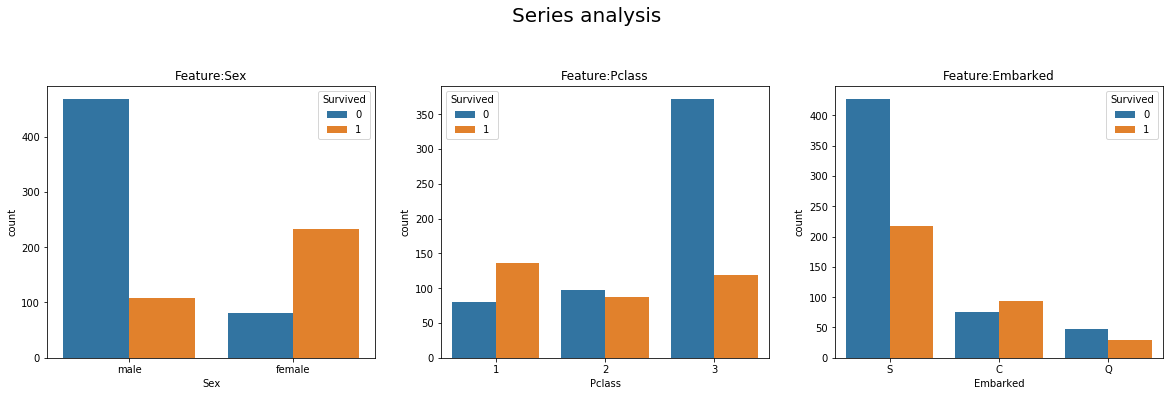

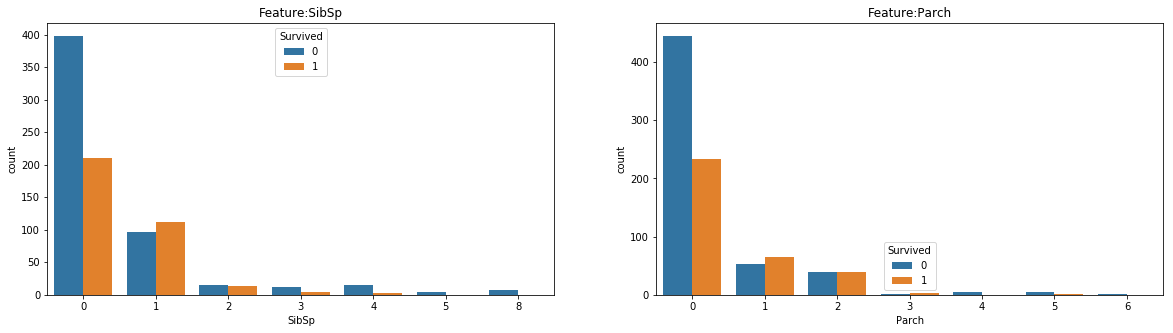

In [4]:
# data visualisations

f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(x='Sex', hue='Survived', data=train, ax=ax1)
sns.countplot(x='Pclass', hue='Survived', data=train, ax=ax2)
sns.countplot(x='Embarked', hue='Survived', data=train, ax=ax3)
ax1.set_title('Feature:Sex')
ax2.set_title('Feature:Pclass')
ax3.set_title('Feature:Embarked')
f.suptitle('Series analysis', size=20, y=1.1)

f, [ax1, ax2] = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x='SibSp', hue='Survived', data=train, ax=ax1)
sns.countplot(x='Parch', hue='Survived', data=train, ax=ax2)
ax1.set_title('Feature:SibSp')
ax2.set_title('Feature:Parch')
plt.show()

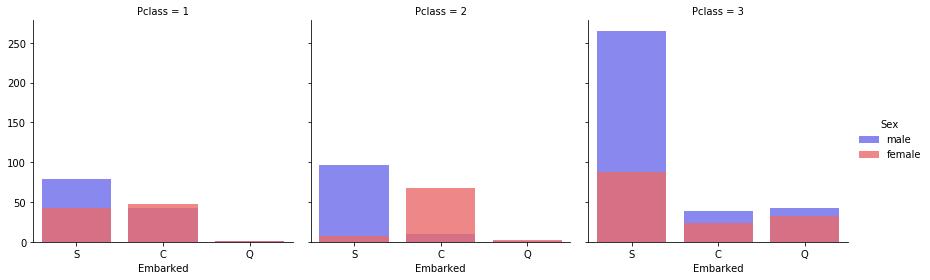

In [5]:
grid = sns.FacetGrid(train, col='Pclass', hue='Sex', palette='seismic', size=4)
grid.map(sns.countplot, 'Embarked', alpha=0.8)
grid.add_legend()

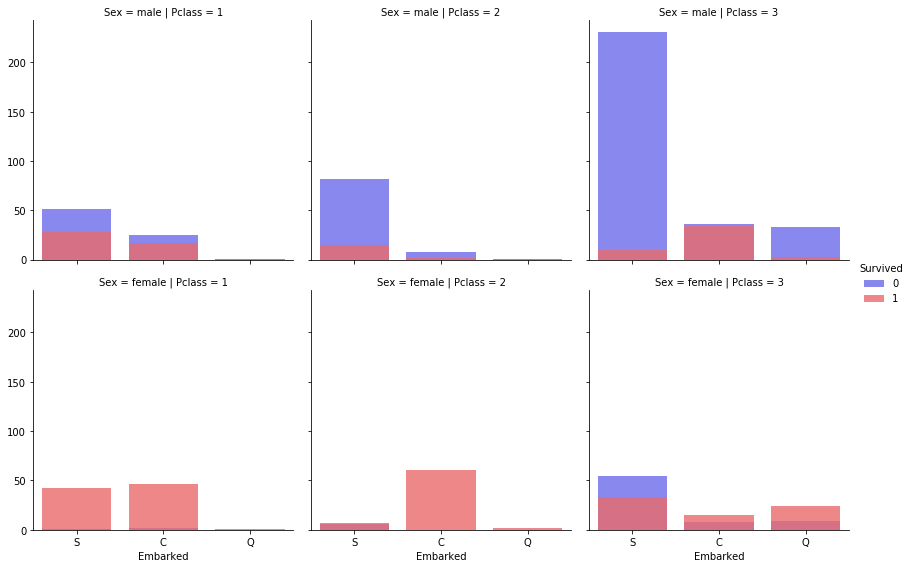

In [6]:
grid2 = sns.FacetGrid(train,col='Pclass',row='Sex',hue='Survived',palette='seismic',size=4)
grid2.map(sns.countplot,'Embarked',alpha=0.8)
grid2.add_legend()

Text(0, 0.5, 'Frequency')

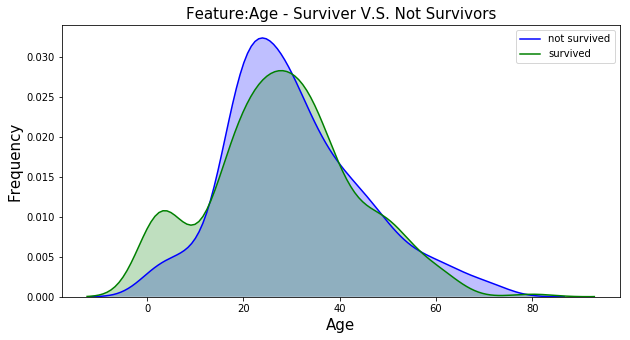

In [7]:
f,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(train.loc[(train['Survived'] == 0),'Age'] , color='b',shade=True,label='not survived')
sns.kdeplot(train.loc[(train['Survived'] == 1),'Age'] , color='g',shade=True, label='survived')
plt.title('Feature:Age - Surviver V.S. Not Survivors', fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

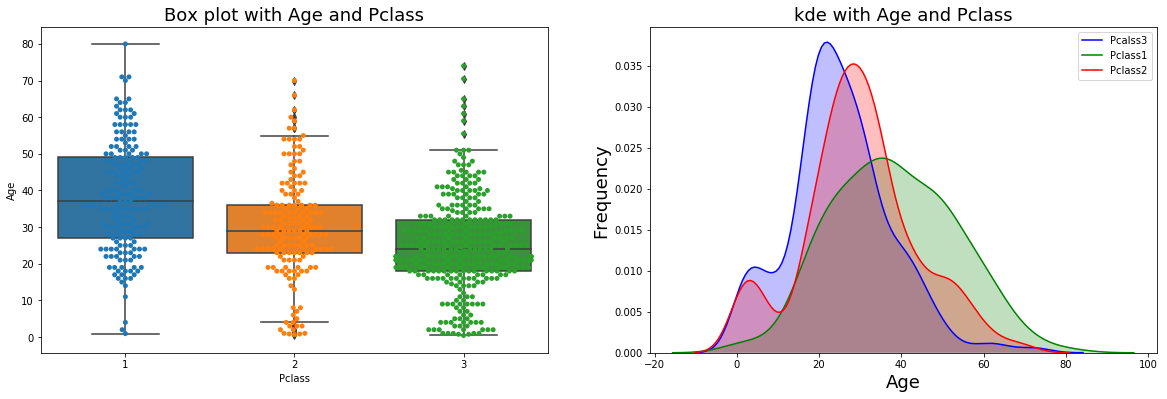

In [8]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(20,6))
sns.boxplot(x="Pclass", y="Age", data=train, ax=ax1)
sns.swarmplot(x="Pclass", y="Age", data=train, ax=ax1)
sns.kdeplot(train.loc[(train['Pclass'] == 3),'Age'] , color='b',shade=True, label='Pcalss3',ax=ax2)
sns.kdeplot(train.loc[(train['Pclass'] == 1),'Age'] , color='g',shade=True, label='Pclass1',ax=ax2)
sns.kdeplot(train.loc[(train['Pclass'] == 2),'Age'] , color='r',shade=True, label='Pclass2',ax=ax2)
ax1.set_title('Box plot with Age and Pclass', fontsize = 18)
ax2.set_title("kde with Age and Pclass", fontsize = 18)
plt.xlabel("Age",fontsize = 18)
plt.ylabel("Frequency", fontsize = 18)
fig.show()

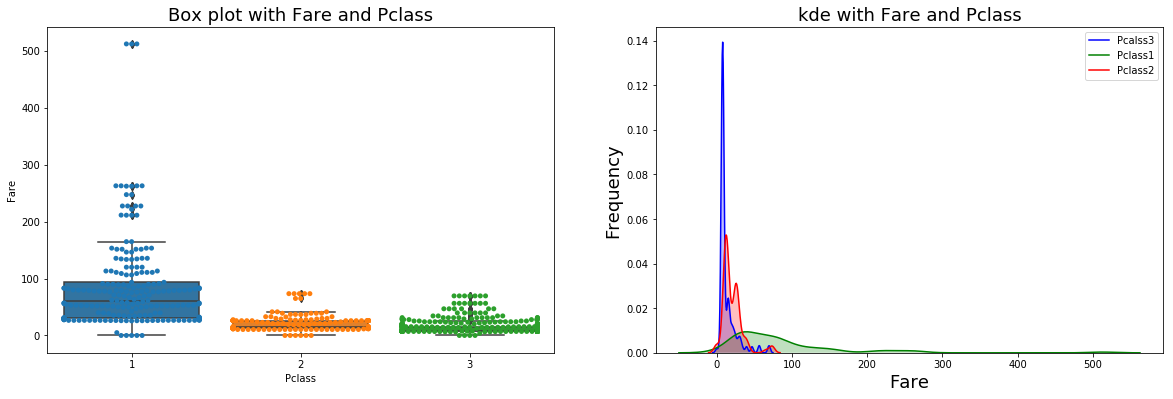

In [9]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(20,6))
sns.boxplot(x="Pclass", y="Fare", data=train, ax =ax1)
sns.swarmplot(x="Pclass", y="Fare", data=train, ax =ax1)
sns.kdeplot(train.loc[(train['Pclass'] == 3),'Fare'] , color='b',shade=True, label='Pcalss3',ax=ax2)
sns.kdeplot(train.loc[(train['Pclass'] == 1),'Fare'] , color='g',shade=True, label='Pclass1',ax=ax2)
sns.kdeplot(train.loc[(train['Pclass'] == 2),'Fare'] , color='r',shade=True, label='Pclass2',ax=ax2)
ax1.set_title('Box plot with Fare and Pclass', fontsize = 18)
ax2.set_title('kde with Fare and Pclass', fontsize = 18)
plt.xlabel("Fare",fontsize = 18)
plt.ylabel("Frequency", fontsize = 18)
fig.show()

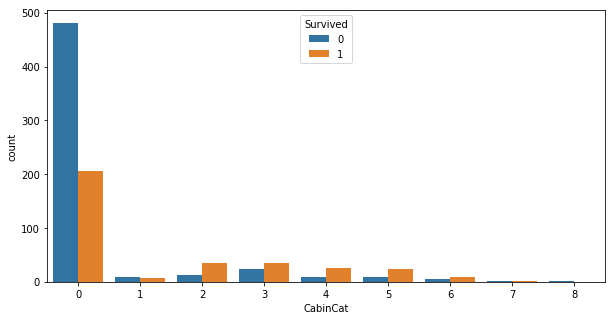

In [10]:
#fill the missing value with reasonable values 
#we have missing values in feature:Age,Cabin,Embarked

#First,deal with Embarked since it has the least null values
#full_data.loc[full_data['Embarked'].isnull()]
#According to the previous data analysis,if the passenger is female in Pclass 1 and they survived,
#the most of them were in Embarked C.Then,we fill the null value with 'C'
for data in full_data:
    data['Embarked'] = data['Embarked'].fillna('C')

#Second,deal with Cabin.
#full_data.loc[train['Cabin'].isnull()]
#Since we have about 78% data missing,it will be not possible to fill with random value.
#Thus,we regard the null as the new type of value,encoding with 0.After that,the first letter in
#origin Cabin will become the new type of value. e.g. A34 = A,B96 = B,NaN = 0
for data in full_data:
    data['Cabin'] = data['Cabin'].fillna('0')
    data['Cabin'] = data['Cabin'].apply(lambda x :x[0])
    data['CabinCat'] = pd.Categorical(data['Cabin']).codes
    data['CabinCat'] = data['CabinCat'].astype(int)
#Visualization
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='CabinCat', hue='Survived',data=train)
plt.show()


In [11]:
# transform some categorical features
# print(train[['Pclass', 'Survived']].groupby(['Pclass']).mean())
# print(train[['Sex', 'Survived']].groupby(['Sex']).mean())

# 1.create new feature for family size
for data in full_data:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
print(train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

# 2.create new feature for IsAlone
for data in full_data:
    data['IsAlone'] = 0
    data.loc[data['FamilySize'] == 1, ['IsAlone']] = 1
print(train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

# 3.create new feature for categoricalFare
for data in full_data:
    data['CategoricalFare'] = pd.qcut(data['Fare'], 4)
print(train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())


# 4.fill all null in Age with random value between (mean-std,mean+std) and create new feature for CategoricalAge
for data in full_data:
    age_mean = data['Age'].mean()
    age_std = data['Age'].std()
    age_null = data['Age'].isnull().sum()

    random_list = np.random.randint(age_mean - age_std, age_mean + age_std, size=age_null)
    data['Age'][np.isnan(data['Age'])] = random_list
    data['Age'] = data['Age'].astype(int)
    data['CategoricalAge'] = pd.qcut(data['Age'], 5)
print(train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

# 6.find out the title of name and calculate the ration of survived
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""
for data in full_data:
    data['Title'] = data['Name'].apply(get_title)
print(pd.crosstab(train['Title'], train['Sex']))

# 7.create new feature for namelength
for data in full_data:
    data["NameLength"] = data["Name"].apply(lambda x: len(x))

# 8.create new label:Childn and new feature Person:Child,female_adult,male_adult.Noted them with 0,1 and 2
child_age = 18
def get_age(passenger):
    age,sex = passenger
    if age <= 18:
        return '0'
    elif sex == 'female':
        return '1'
    else:
        return '2'

for data in full_data:
    data['Person'] = data[['Age','Sex']].apply(get_age,axis=1)


   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
   IsAlone  Survived
0        0  0.505650
1        1  0.303538
   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081
   CategoricalAge  Survived
0  (-0.001, 19.0]  0.481675
1    (19.0, 25.0]  0.316092
2    (25.0, 32.0]  0.381720
3    (32.0, 40.0]  0.362069
4    (40.0, 80.0]  0.367470
Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1

In [12]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Name               891 non-null object
Sex                891 non-null object
Age                891 non-null int32
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null float64
Cabin              891 non-null object
Embarked           891 non-null object
CabinCat           891 non-null int32
FamilySize         891 non-null int64
IsAlone            891 non-null int64
CategoricalFare    891 non-null category
CategoricalAge     891 non-null category
Title              891 non-null object
NameLength         891 non-null int64
Person             891 non-null object
dtypes: category(2), float64(1), int32(2), int64(8), object(7)
memory usage: 120.3+ KB
None


In [13]:
#mapping non-categorical value to categorical
for data in full_data:
    #map Sex
    data['Sex'] = data['Sex'].map({'female': 0, 'male': 1}).astype(int)
    #map Embarked
    data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    #map Fare
    data.loc[ data['Fare'] <= 7.896, 'Fare'] = 0
    data.loc[(data['Fare'] > 7.896) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31.275), 'Fare']   = 2
    data.loc[ data['Fare'] > 31.275, 'Fare'] = 3
    #data['Fare'] = data['Fare'].astype(int)
    #map Title
    data['TitleCat'] = data['Title'].map(
    {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, 
     "Rev": 6, "Major": 7, "Col": 7, "Mlle": 2, "Mme": 3,
     "Don": 9,"Dona": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10,
     "Sir": 9, "Capt": 7, "Ms": 2} ).astype(int)
    # Mapping Age
    data.loc[ data['Age'] <= 16, 'Age'] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age'] = 4

#fill one Nan value in test set
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [14]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Name               891 non-null object
Sex                891 non-null int32
Age                891 non-null int32
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null float64
Cabin              891 non-null object
Embarked           891 non-null int32
CabinCat           891 non-null int32
FamilySize         891 non-null int64
IsAlone            891 non-null int64
CategoricalFare    891 non-null category
CategoricalAge     891 non-null category
Title              891 non-null object
NameLength         891 non-null int64
Person             891 non-null object
TitleCat           891 non-null int32
dtypes: category(2), float64(1), int32(5), int64(8), object(5)
memory usage: 116.8+ 

In [15]:
print(train.keys())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'CabinCat',
       'FamilySize', 'IsAlone', 'CategoricalFare', 'CategoricalAge', 'Title',
       'NameLength', 'Person', 'TitleCat'],
      dtype='object')


In [16]:
#drop some unuseful label
drop_elements = ['PassengerId','Name','Ticket','Cabin','Title']
train = train.drop(drop_elements,axis=1)
train = train.drop(['CategoricalFare','CategoricalAge'],axis=1)
test = test.drop(drop_elements,axis=1)
test = test.drop(['CategoricalFare','CategoricalAge'],axis=1)

In [17]:
print(train.describe())
print(test.describe())

         Survived      Pclass         Sex         Age       SibSp       Parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.647587    1.356902    0.523008    0.381594   
std      0.486592    0.836071    0.477990    0.844350    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000    1.000000    0.000000    0.000000   
50%      0.000000    3.000000    1.000000    1.000000    0.000000    0.000000   
75%      1.000000    3.000000    1.000000    2.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000    4.000000    8.000000    6.000000   

             Fare    Embarked    CabinCat  FamilySize     IsAlone  NameLength  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     1.497194    0.363636    0.776655    1.904602    0.602694   26.965208   
std      1.111100    0.6361

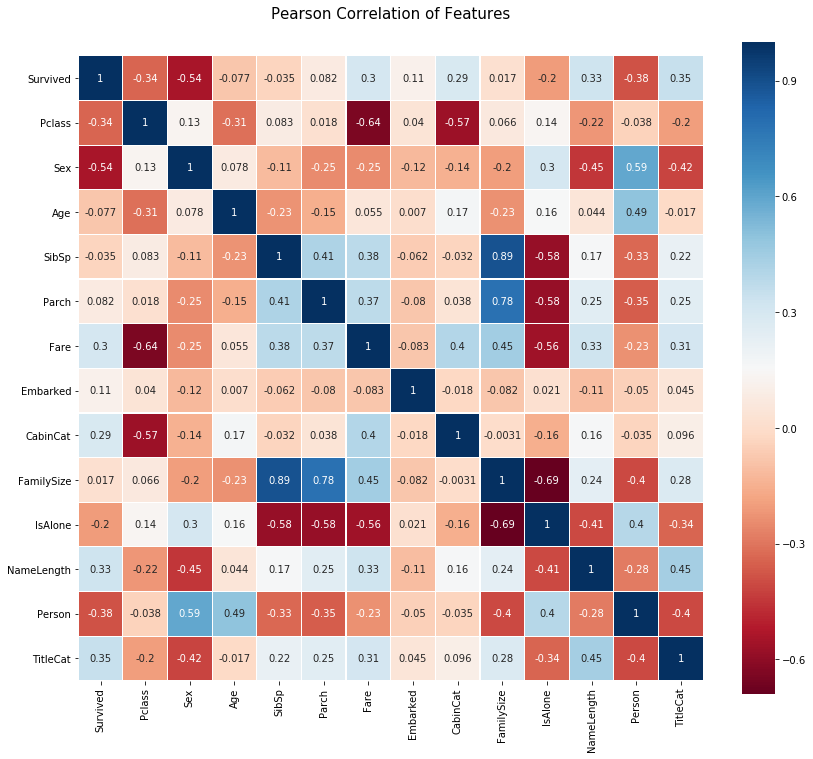

In [18]:
#Pearson Correlation Heatmap
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [19]:
#ANOVA 
target = train["Survived"].values
features= ['Age','Sex','TitleCat','Pclass','NameLength','CabinCat', 'SibSp', 'Parch',
           'Fare','Embarked','FamilySize','IsAlone','Person']

train = train.copy()
test = test.copy()

selector = SelectKBest(f_classif, k=len(features))
selector.fit(train[features], target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance :")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]],features[indices[f]]))

Features importance :
68.85 Sex
31.37 Person
26.22 TitleCat
24.60 Pclass
23.69 NameLength
19.69 Fare
17.75 CabinCat
9.05 IsAlone
3.05 Embarked
1.83 Parch
1.66 Age
0.53 SibSp
0.21 FamilySize


In [20]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'],axis=1)
x_train = train.values
x_test = test.values
data = np.concatenate((x_train,x_test))

In [22]:
ntrain = train.shape[0]
ntest = test.shape[0]
seed = 0
kfolds = KFold(n_splits=10)

In [23]:
#create a function that can apply CV to multiple classifiers
def result(clf,x_train,y_train,x_test):
    re_train = np.zeros((ntrain,))
    re_test = np.zeros((ntest,))
    re_test_kf = np.empty((10,ntest))
    for i,(train_index,test_index) in enumerate(kfolds.split(x_train)):
        xt,xte = x_train[train_index],x_train[test_index]
        yt,yte = y_train[train_index],y_train[test_index]
        clf.fit(xt,yt)
        re_train[test_index] = clf.predict(xte)
        re_test_kf[i,:] = clf.predict(x_test)
    re_test[:] = re_test_kf.mean(axis=0)
    return re_train.reshape(-1,1),re_test.reshape(-1,1)

In [24]:
#define params for each classifier
rf_params = {
    'n_estimators':500,
    'max_depth' : 6,
    'n_jobs' : -1,
    'warm_start' : True,
}

ada_params = {
    'n_estimators' :500,
    'learning_rate':0.75
}

gb_params = {
    'learning_rate':0.75,
    'n_estimators':500,
    'warm_start':True,
    'min_samples_leaf':2
}

et_params = {
    'n_estimators':500,
    'max_depth':8,
    'min_samples_leaf': 2
}

svc_params = {
    'kernel':'linear',
    'C':0.025
}


In [25]:
#create first-level classifiers
ada = AdaBoostClassifier(n_estimators=500,learning_rate=0.75)
et = ExtraTreesClassifier(n_estimators=500,max_depth=8,min_samples_leaf=2)
rf = RandomForestClassifier(n_estimators=500,max_depth=6,n_jobs=-1,warm_start=True)
gb = GradientBoostingClassifier(learning_rate=0.75,n_estimators=500,warm_start=True,min_samples_leaf=2)
svc = SVC(kernel='linear',C=0.025)

In [26]:
#get the train and test results by using result function 
rf_train,rf_test = result(rf,x_train,y_train,x_test)
et_train,et_test = result(et,x_train,y_train,x_test)
ada_train,ada_test = result(ada,x_train,y_train,x_test)
gb_train,gb_test = result(gb,x_train,y_train,x_test)
svc_train,svc_test = result(svc,x_train,y_train,x_test)

In [27]:
#create second-level classifier by using xgboost
first_prediction = pd.DataFrame({
    'RandomForest':rf_train.ravel(),
    'ExtraTrees':et_train.ravel(),
    'AdaBoost':ada_train.ravel(),
    'Gradient':gb_train.ravel(),
    'SVC':svc_train.ravel()
})

In [29]:
#plot the first-level classifiers by correlation heatmap
data = [
    go.Heatmap(
        z= first_prediction.astype(float).corr().values ,
        x=first_prediction.columns.values,
        y= first_prediction.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [30]:
x_train = np.concatenate(( et_train, rf_train, ada_train, gb_train, svc_train), axis=1)
x_test = np.concatenate(( et_test, rf_test, ada_test, gb_test, svc_test), axis=1)

In [31]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [32]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)